In [10]:
import pandas as pd
import numpy as np
import xgboost
import sys

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline



sys.path.append("C:\\Users\\isvys\\Projects\\nnboost\\")
from nnboost import NNBoostRegressor

# Pre-defined functions

In [11]:
def num_cat_split(df):
    '''returns list of numerical and categorical columns'''
    
    num_col = list(df.select_dtypes(include=['number']).columns)
    cat_col = list(set(df.columns) - set(num_col))

    print(f"Numerical columns : \n{num_col}")
    print("")
    print(f"Categorical columns :\n {cat_col}")
    
    return num_col, cat_col

# 1. Load Data

In [12]:
DF = pd.read_csv('datasets/train.csv')
DF

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# 2. N/A Columns

In [13]:
p = 0.3 # columns with more than 30 n/a rows 
df_rows = DF.shape[0]
na_freq = DF.isna().sum().sort_values(ascending=False) / df_rows
na_freq = na_freq[na_freq > 0.3]

In [14]:
na_columns = na_freq.index

In [15]:
na_num_col, na_cat_col = num_cat_split(DF[na_columns])

Numerical columns : 
[]

Categorical columns :
 ['MiscFeature', 'Fence', 'Alley', 'PoolQC', 'FireplaceQu']


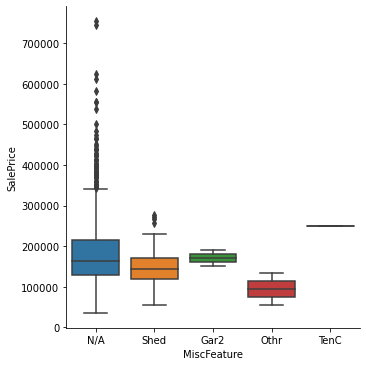

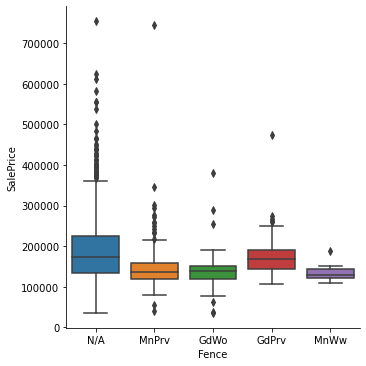

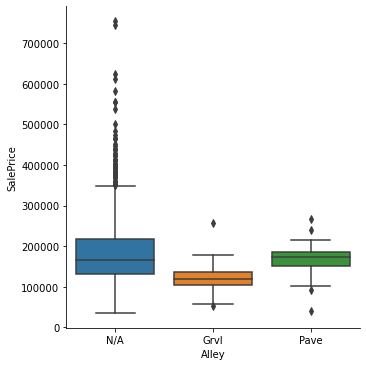

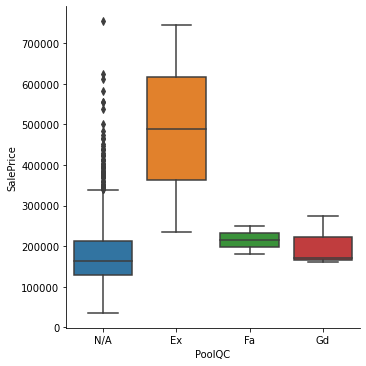

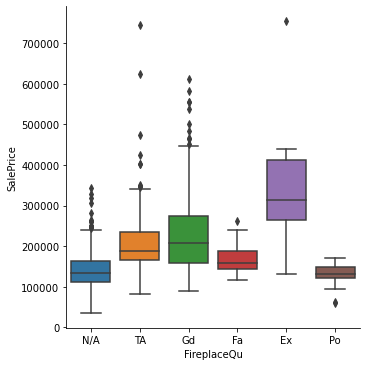

In [16]:
for c in na_cat_col:
    sns.catplot(x=c, y='SalePrice', kind='box', data=DF[na_cat_col+["SalePrice"]].fillna('N/A'))

In [17]:
DROPED_COLUMNS = ['Alley','Fence', 'MiscFeature']
DF.drop(DROPED_COLUMNS, axis=1, inplace=True)

# 3. Numerical Columns

In [18]:
num_col , _ = num_cat_split(DF)

Numerical columns : 
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorical columns :
 ['Street', 'Utilities', 'ExterQual', 'BsmtFinType1', 'LotShape', 'LandSlope', 'BsmtQual', 'PavedDrive', 'HeatingQC', 'ExterCond', 'Heating', 'Neighborhood', 'BsmtExposure', 'Exterior2nd', 'HouseStyle', 'GarageType', 'GarageFinish', 'BsmtCond', 'Electrical', 'CentralAir', 'Condition1', 'Condition2', 'Foundation', 'Functional', 'BldgType', 'BsmtFinType2', 'MasVnrType', 'RoofMatl', 'PoolQC', 'LandContour', 'SaleCondition', 'Exterior1s

In [19]:
# g = sns.PairGrid(DF[num_col])
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)

In [20]:
num_SalesPrice_corr = DF[num_col].corr()['SalePrice'].sort_values(ascending=False)[1:]
mask =(num_SalesPrice_corr>0.3) | (num_SalesPrice_corr < -0.3)
high_num_SalesPrice_corr = num_SalesPrice_corr[mask]
low_num_SalesPrice_corr = num_SalesPrice_corr[~mask]

In [21]:
num_SalesPrice_corr

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [22]:
high_num_SalesPrice_corr_df = DF[high_num_SalesPrice_corr.index].corr()
for c in high_num_SalesPrice_corr.index:
    print(c, '-->', high_num_SalesPrice_corr_df[c].sort_values(ascending=False)[1:])

OverallQual --> GarageCars      0.600671
GrLivArea       0.593007
YearBuilt       0.572323
GarageArea      0.562022
YearRemodAdd    0.550684
FullBath        0.550600
GarageYrBlt     0.547766
TotalBsmtSF     0.537808
1stFlrSF        0.476224
TotRmsAbvGrd    0.427452
MasVnrArea      0.411876
Fireplaces      0.396765
OpenPorchSF     0.308819
2ndFlrSF        0.295493
LotFrontage     0.251646
BsmtFinSF1      0.239666
WoodDeckSF      0.238923
Name: OverallQual, dtype: float64
GrLivArea --> TotRmsAbvGrd    0.825489
2ndFlrSF        0.687501
FullBath        0.630012
OverallQual     0.593007
1stFlrSF        0.566024
GarageArea      0.468997
GarageCars      0.467247
Fireplaces      0.461679
TotalBsmtSF     0.454868
LotFrontage     0.402797
MasVnrArea      0.390857
OpenPorchSF     0.330224
YearRemodAdd    0.287389
WoodDeckSF      0.247433
GarageYrBlt     0.231197
BsmtFinSF1      0.208171
YearBuilt       0.199010
Name: GrLivArea, dtype: float64
GarageCars --> GarageArea      0.882475
OverallQual   

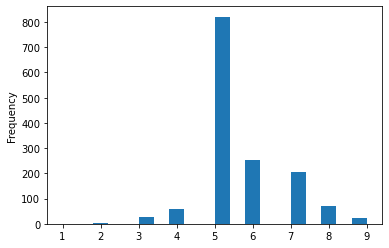

In [23]:
DF['OverallCond'].plot(kind='hist', bins=20)

In [24]:
DROPED_COLUMNS = ['KitchenAbvGr', 'MSSubClass', 'MiscVal', 'EnclosedPorch', 'YrSold', 'ScreenPorch', 'LowQualFinSF', 'Id', 'PoolArea', '3SsnPorch', 'BsmtHalfBath', 'BsmtFinSF2'] 
DF.drop(DROPED_COLUMNS, axis=1, inplace=True)




# 4. Categorical Columns

In [25]:
_ , cat_col = num_cat_split(DF)

Numerical columns : 
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'SalePrice']

Categorical columns :
 ['Street', 'Utilities', 'ExterQual', 'BsmtFinType1', 'LotShape', 'LandSlope', 'BsmtQual', 'PavedDrive', 'HeatingQC', 'ExterCond', 'Heating', 'Neighborhood', 'BsmtExposure', 'Exterior2nd', 'HouseStyle', 'GarageType', 'GarageFinish', 'BsmtCond', 'Electrical', 'CentralAir', 'Condition1', 'Condition2', 'Foundation', 'Functional', 'BldgType', 'BsmtFinType2', 'MasVnrType', 'RoofMatl', 'PoolQC', 'LandContour', 'SaleCondition', 'Exterior1st', 'KitchenQual', 'FireplaceQu', 'SaleType', 'MSZoning', 'LotConfig', 'RoofStyle', 'GarageQual', 'GarageCond']


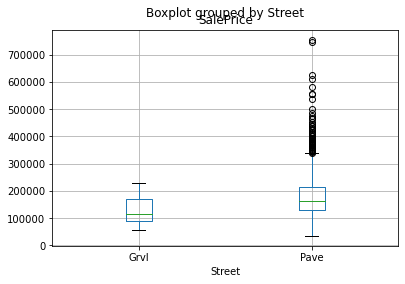

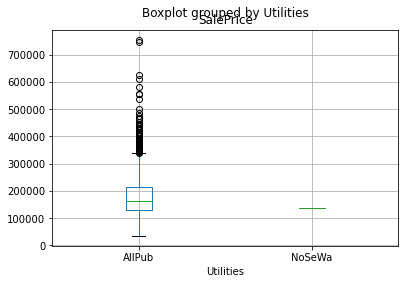

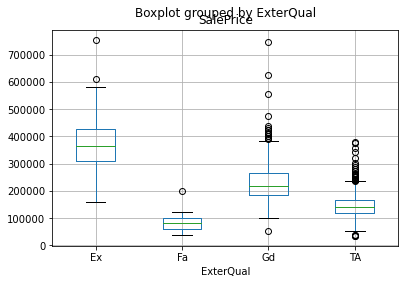

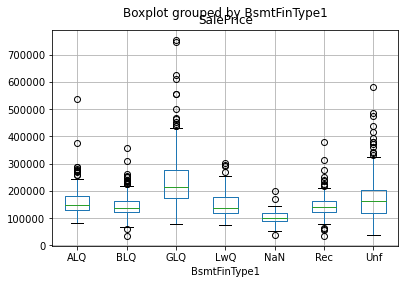

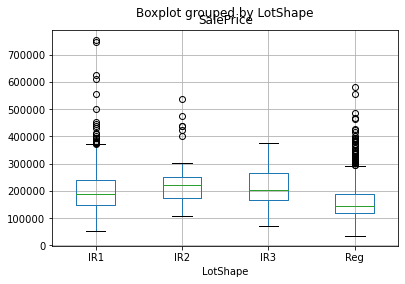

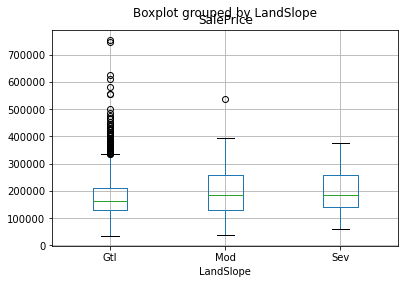

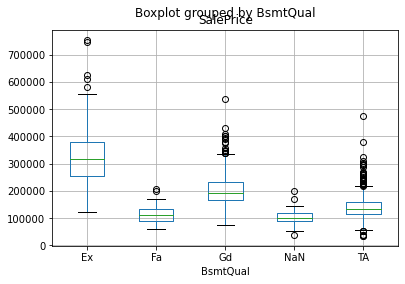

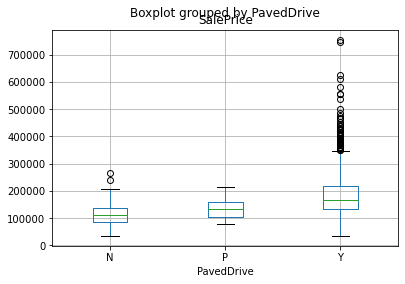

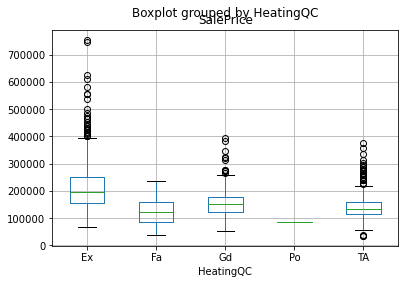

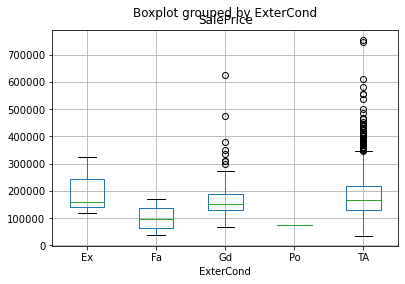

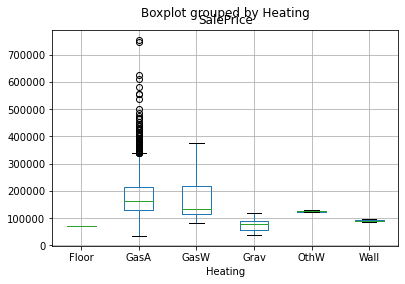

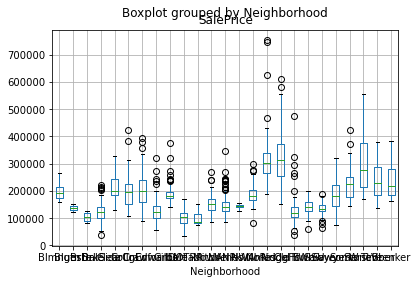

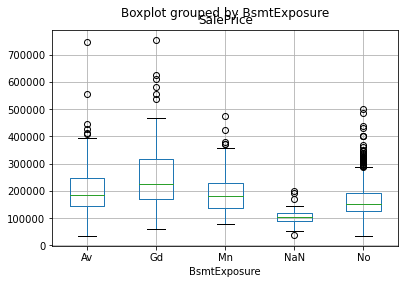

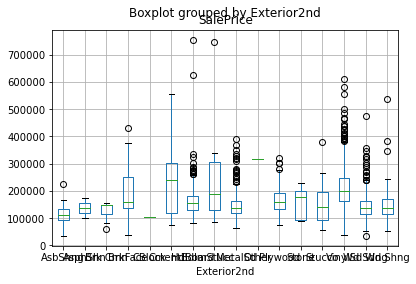

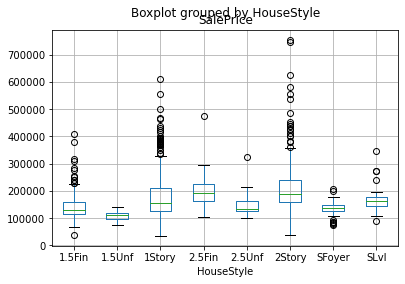

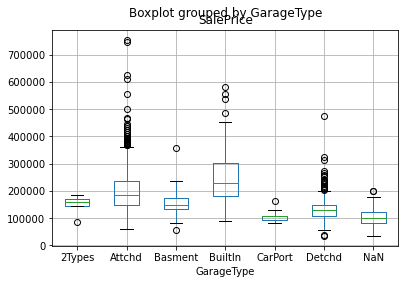

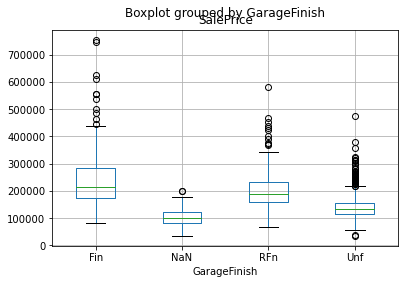

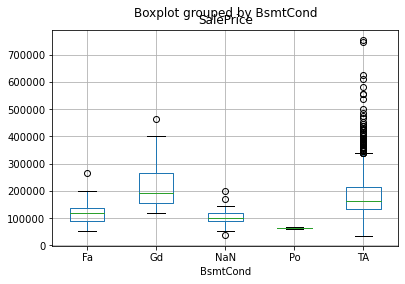

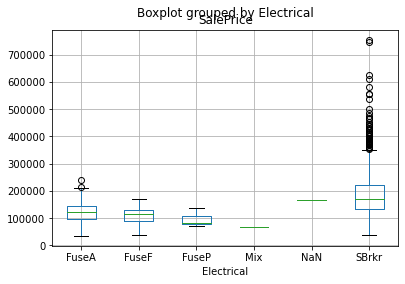

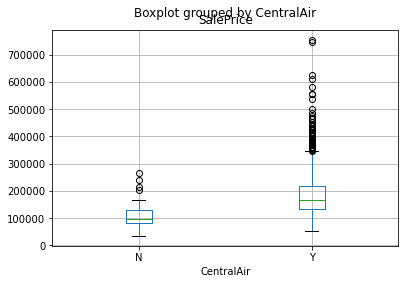

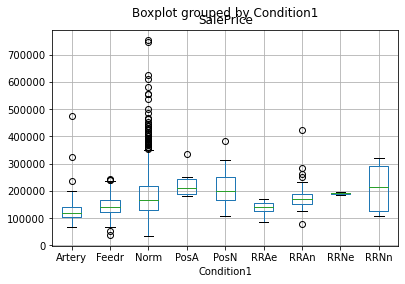

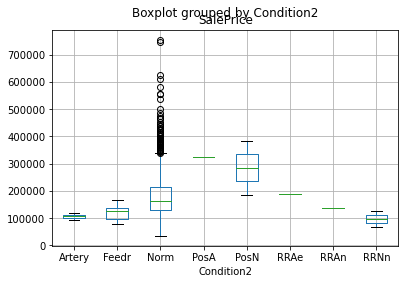

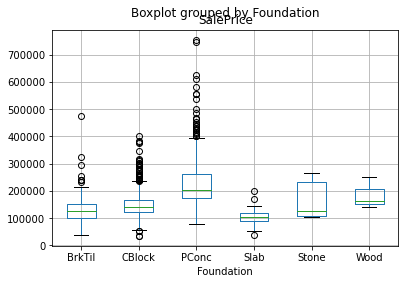

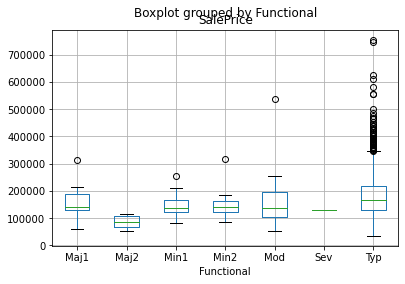

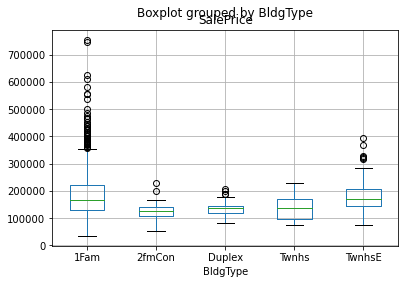

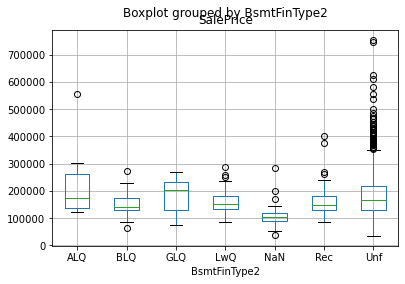

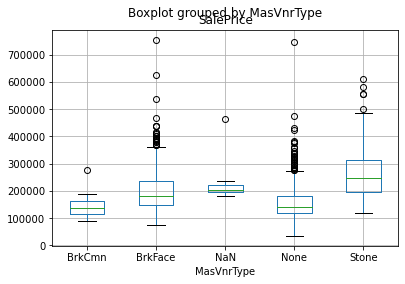

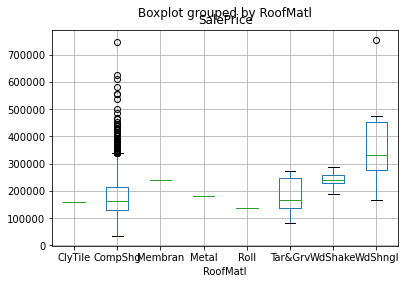

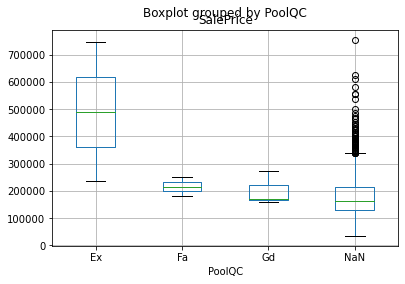

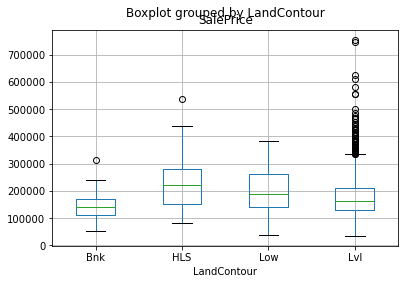

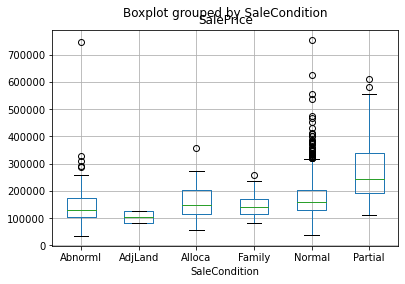

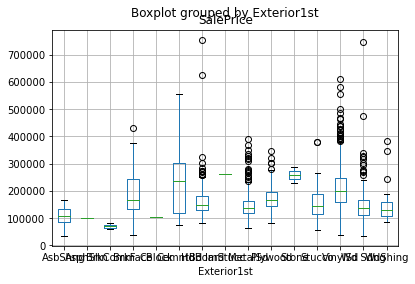

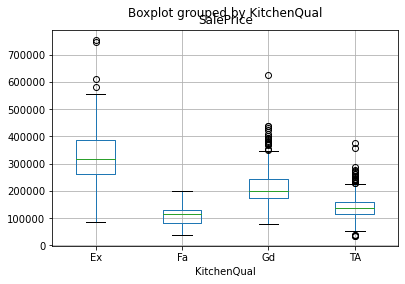

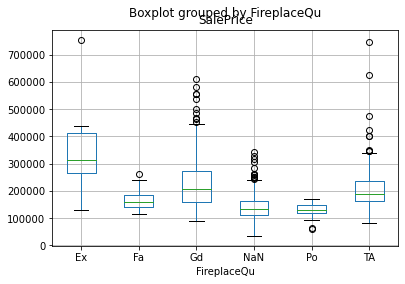

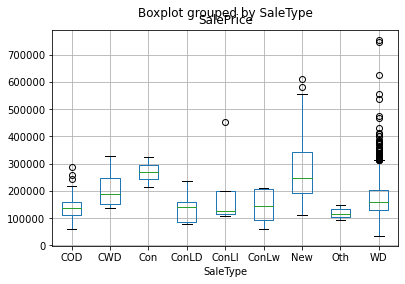

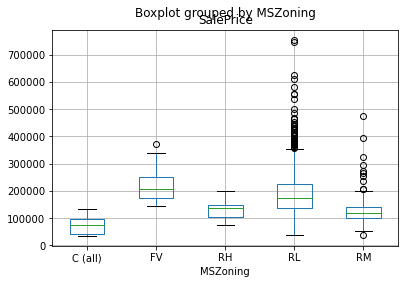

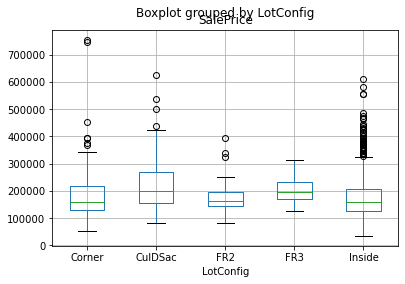

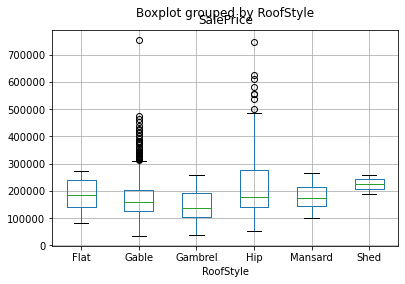

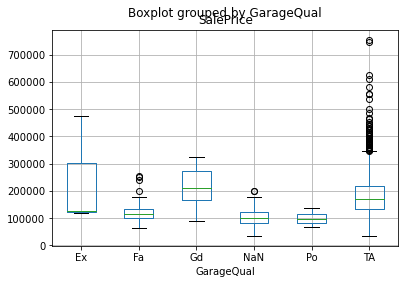

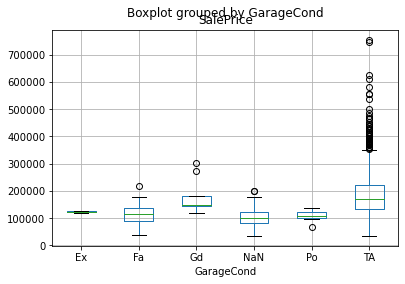

In [26]:
cat_df = DF[cat_col+['SalePrice']].fillna('NaN')
for c in cat_col:
    cat_df.boxplot("SalePrice", by=c)
    plt.show()

In [27]:
DROPED_COLUMNS = []
cat_df = DF[cat_col].fillna('N/A').copy()
for c in cat_df.columns:
    if cat_df[c].value_counts(normalize=True).iloc[0]>0.9:
        DROPED_COLUMNS.append(c)
DROPED_COLUMNS.remove('CentralAir')
DROPED_COLUMNS.extend(['LandContour', 'LotConfig', 'ExterCond', 'HouseStyle', 'HeatingQC', 'RoofStyle', 'Condition1', 'LotShape', 'BsmtFinType2', 'GarageCond'])
print(DROPED_COLUMNS)


['Street', 'Utilities', 'LandSlope', 'PavedDrive', 'Heating', 'Electrical', 'Condition2', 'Functional', 'RoofMatl', 'PoolQC', 'GarageCond', 'LandContour', 'LotConfig', 'ExterCond', 'HouseStyle', 'HeatingQC', 'RoofStyle', 'Condition1', 'LotShape', 'BsmtFinType2', 'GarageCond']


In [28]:
DF.drop(DROPED_COLUMNS, axis=1, inplace=True)   


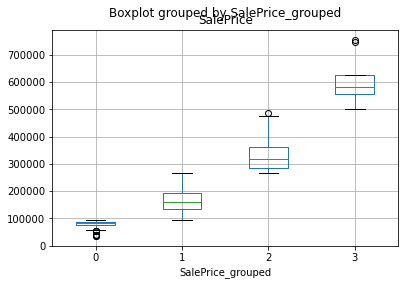

In [29]:
bins = (np.linspace(0, 1, 5)**1.5) * DF['SalePrice'].max()
DF['SalePrice_grouped'] = pd.cut(DF['SalePrice'], 
                                         bins=bins,
                                         labels=range(len(bins)-1))
DF.boxplot('SalePrice', by='SalePrice_grouped')

In [31]:
X = DF.drop(['SalePrice','SalePrice_grouped'], axis=1).copy()
_y = DF[['SalePrice', 'SalePrice_grouped']]

In [32]:
X

,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,MoSold,SaleType,SaleCondition
0,RL,65.0,8450,CollgCr,1Fam,7,5,2003,2003,VinylSd,...,2003.0,RFn,2,548,TA,0,61,2,WD,Normal
1,RL,80.0,9600,Veenker,1Fam,6,8,1976,1976,MetalSd,...,1976.0,RFn,2,460,TA,298,0,5,WD,Normal
2,RL,68.0,11250,CollgCr,1Fam,7,5,2001,2002,VinylSd,...,2001.0,RFn,2,608,TA,0,42,9,WD,Normal
3,RL,60.0,9550,Crawfor,1Fam,7,5,1915,1970,Wd Sdng,...,1998.0,Unf,3,642,TA,0,35,2,WD,Abnorml
4,RL,84.0,14260,NoRidge,1Fam,8,5,2000,2000,VinylSd,...,2000.0,RFn,3,836,TA,192,84,12,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Gilbert,1Fam,6,5,1999,2000,VinylSd,...,1999.0,RFn,2,460,TA,0,40,8,WD,Normal
1456,RL,85.0,13175,NWAmes,1Fam,6,6,1978,1988,Plywood,...,1978.0,Unf,2,500,TA,349,0,2,WD,Normal
1457,RL,66.0,9042,Crawfor,1Fam,7,9,1941,2006,CemntBd,...,1941.0,RFn,1,252,TA,0,60,5,WD,Normal
1458,RL,68.0,9717,NAmes,1Fam,5,6,1950,1996,MetalSd,...,1950.0,Unf,1,240,TA,366,0,4,WD,Normal


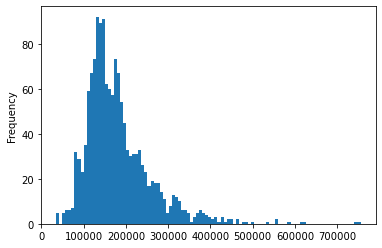

In [33]:
_y['SalePrice'].plot(kind='hist', bins=100)

In [34]:
X_train, X_valid, _y_train, _y_valid = train_test_split(X, _y, test_size=.2, random_state=77,  stratify=_y.SalePrice_grouped)
y_train = _y_train.SalePrice
y_valid = _y_valid.SalePrice

In [35]:
X_train

,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,MoSold,SaleType,SaleCondition
755,FV,34.0,3230,Somerst,TwnhsE,6,5,1999,1999,MetalSd,...,1999.0,Unf,2,440,TA,0,24,3,WD,Normal
1024,RL,NaN,15498,Timber,1Fam,8,6,1976,1976,Stone,...,1976.0,Fin,2,665,TA,0,72,5,COD,Abnorml
521,RL,90.0,11988,NAmes,1Fam,6,6,1957,1957,VinylSd,...,1957.0,Unf,1,336,TA,0,40,5,WD,Normal
437,RM,50.0,6000,BrkSide,1Fam,6,7,1926,2004,Wd Sdng,...,1926.0,Unf,1,180,TA,0,0,1,WD,Normal
937,RL,75.0,9675,Somerst,1Fam,7,5,2005,2005,VinylSd,...,2005.0,RFn,2,689,TA,0,48,2,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,RL,60.0,7200,NAmes,1Fam,5,8,1950,2002,VinylSd,...,1980.0,RFn,2,720,TA,194,0,7,WD,Normal
434,RM,21.0,1890,MeadowV,Twnhs,4,7,1972,1972,CemntBd,...,NaN,NaN,0,0,NaN,88,0,6,WD,Normal
471,RL,92.0,11952,NWAmes,1Fam,7,6,1977,1977,WdShing,...,1977.0,RFn,2,534,TA,0,0,11,WD,Normal
889,RL,128.0,12160,NAmes,1Fam,6,4,1953,1953,Wd Sdng,...,1953.0,RFn,2,505,TA,0,0,2,WD,Normal


In [36]:
num_col, cat_col = num_cat_split(X)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('numerical_scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(fill_value='NA', strategy='constant')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])


Numerical columns : 
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold']

Categorical columns :
 ['ExterQual', 'BsmtFinType1', 'BsmtQual', 'BsmtExposure', 'Neighborhood', 'Exterior2nd', 'GarageType', 'GarageFinish', 'BsmtCond', 'CentralAir', 'Foundation', 'BldgType', 'MasVnrType', 'SaleCondition', 'Exterior1st', 'KitchenQual', 'FireplaceQu', 'SaleType', 'MSZoning', 'GarageQual']


In [51]:
# model = NNBoostRegressor(n_estimators=80, learning_rate=0.3,base_model_method='median', degree=1, seed=1234)
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1)

In [52]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [53]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('numerical_scaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'B...
    

In [54]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

In [55]:
y_valid -preds

918    -22603.687500
566     -2734.093750
1303    13523.250000
1316    46496.031250
495    -48153.687500
            ...     
730    -21434.640625
119     -9209.468750
315     -2882.734375
1202    -6918.742188
699     16653.171875
Name: SalePrice, Length: 292, dtype: float64

In [56]:
y_valid

918     238000
566     325000
1303    232000
1316    295493
495      34900
         ...  
730     236500
119     163990
315     188500
1202    117000
699     196000
Name: SalePrice, Length: 292, dtype: int64

In [57]:
# Evaluate the model
score = mean_absolute_error(y_valid, preds)
rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(preds)))
print('MAE:', score)
print('RMSE:', rmse)

MAE: 18067.693680436645
RMSE: 0.1616946016162712


In [62]:
import x

'1.20.1'

In [59]:
import tensorflow

# Submision

In [ ]:
m = sorted(results, key= lambda x: x[1])[-1][-1]

In [ ]:
sorted(results, key= lambda x: x[1])[1]

In [ ]:
X_test = pd.read_csv('datasets/test.csv')
Id = X_test['Id']
X_test = X_test[X_valid.columns]
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'Id': Id,
                       'SalePrice': preds_test})
output.to_csv('submission13.csv', index=False)

In [ ]:
DF_cat = DF[cat_col].copy()
DF_cat.fillna('XXX', inplace=True)
dominante_col = []
for i, c in enumerate(cat_col):
    _df = DF_cat[c].value_counts(normalize=True)
    if _df.iloc[0] > 0.85:
        print(f"[{c}]")
        dominante_col.append(c)
        print(_df)
        print("")

In [ ]:
(2-5)**2/2

In [ ]:
a = np.array([1,3,4])
b = np.array([4,5,4])
c = np.array([1,2,2])
np.mean((a-b)/c)

In [ ]:
(sum(a)-sum(b))/sum(c)

In [ ]:
g = 0.1

In [ ]:
o = g*a
o

In [ ]:
np.linalg.pinv(a.reshape(-1,1)).dot(o)[0]

In [ ]:
np.sum(b)

In [ ]:
type('efwe') is str

In [ ]:
X = [0,1,2,3,1,4,2,3]

In [ ]:
import tensorflow as tf
tf.one_hot(X, len(np.unique(X)))

In [ ]:
tf.nn.softmax([0,0,.75, 0])

In [ ]:
9 // 2